In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
def jitter(values, jitter_amount=0.05):
#     return values + np.random.uniform(-jitter_amount, jitter_amount, size=len(values))
    jitter_amount = np.random.uniform(-jitter_amount, jitter_amount, size=1)
    return values + jitter_amount

In [3]:
def plotStaircase_LR(filepath, conditions_to_plot, subj, eccentricity = 8, 
                     printTrialsSentToQuest = False,
                     dispTypicalCrowdingThresholds = False,
                     addJitter = True):

    
    # Read the CSV file
    ee_file = pd.read_csv(filepath)
    
    
    # Colormap and line styles
    cmap = cm.jet(np.linspace(0, 1, 8))
    linestyles = ['-.', '-'] 
    block_ct = -1
    
    plt.figure(figsize=(6, 6)) 
    
    # add patch for typical crowding thresholds (data from Kurzawski, Burchell, 2023)
    if dispTypicalCrowdingThresholds:
        ymin = 0.18 * eccentricity
        ymax = 0.41 * eccentricity
        plt.axhspan(ymin, ymax, color='lightgray', alpha=0.5)


    
    for cond in range(len(conditions_to_plot)):         
            
        condition_name = conditions_to_plot[cond]

        condition_data = ee_file[ee_file['conditionName'] == condition_name]
        
        log_questMeans = condition_data['questMeanBeforeThisTrialResponse']
        
        questMeans = 10 ** log_questMeans
        
        x_vals = np.array(range(len(questMeans)))
        
        if addJitter:
            x_vals = jitter(x_vals,2)
        
        plt.plot(x_vals, questMeans, label=condition_name,
                 color=cmap[cond], linewidth=1, linestyle=linestyles[cond%2])
         
   

    plt.ylim([0.005, 100])
    plt.title(f'Subject {subj}', fontsize=16)
    plt.xlabel('Trials', fontsize=14)
    plt.ylabel('Threshold', fontsize=14)
    plt.gca().set_yscale('log')
    plt.gca().tick_params(labelsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

  

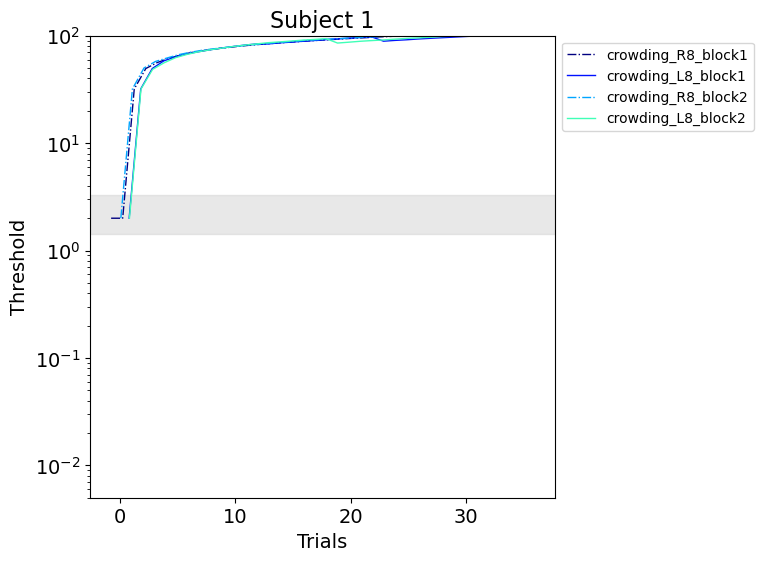

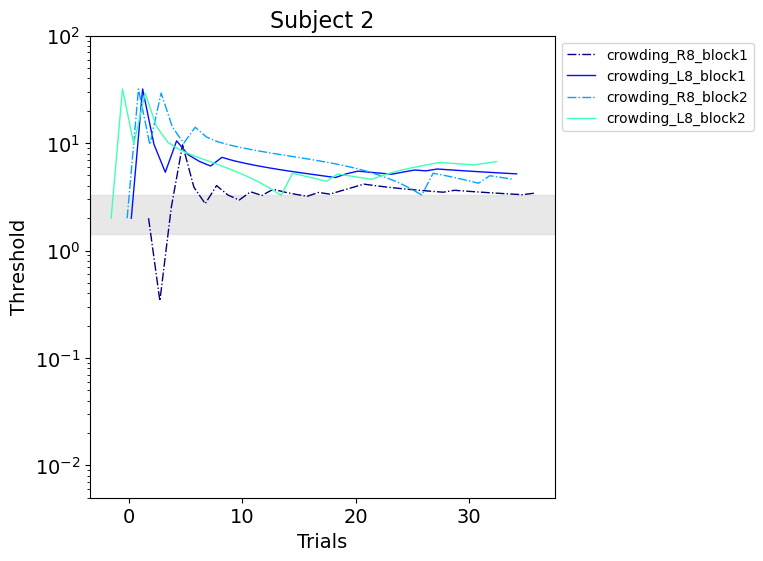

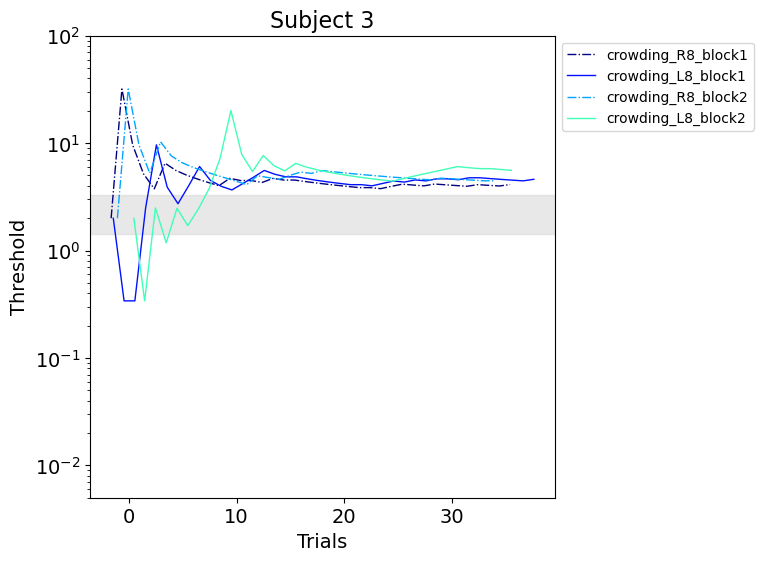

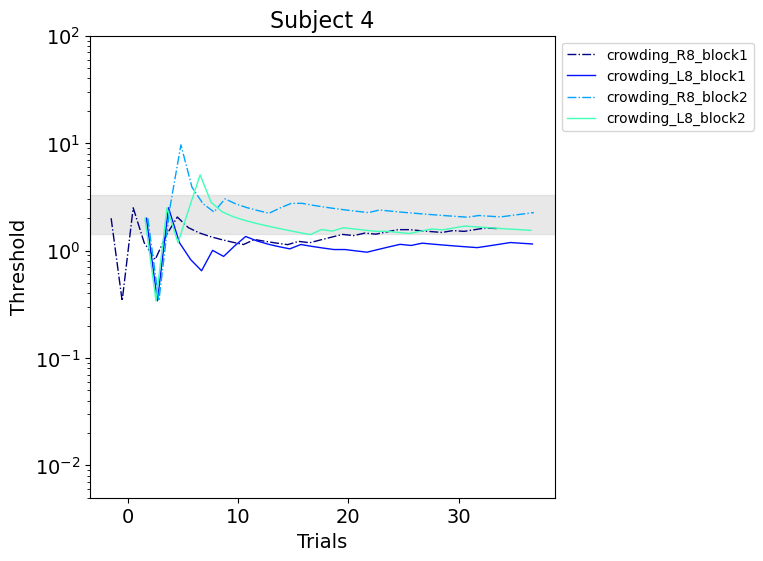

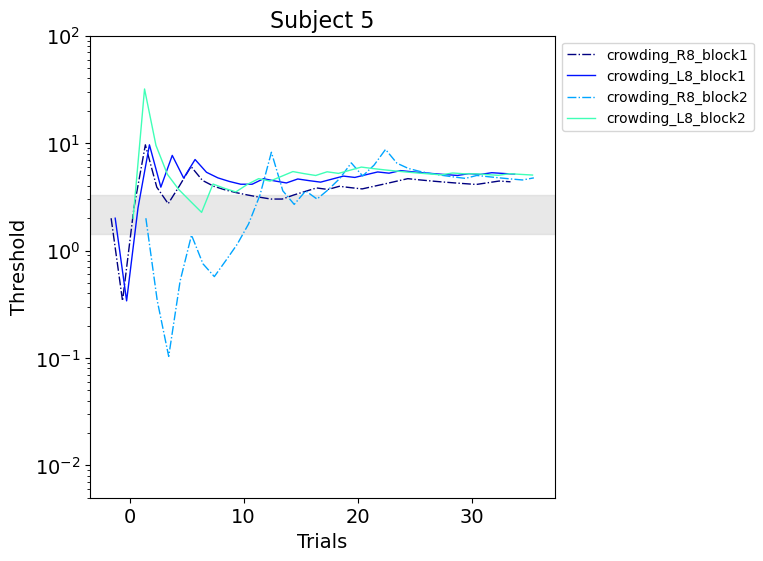

In [4]:
mydir = 'data/corr_firstSess'
files = [f for f in os.listdir(mydir) if f.endswith('.csv')]
num_subj = len(files)
condition_names = ['crowding_R8_block1', 'crowding_L8_block1',
                  'crowding_R8_block2', 'crowding_L8_block2']
                 
for subj in range(num_subj):
    filepath = os.path.join(mydir, files[subj])

    plotStaircase_LR(filepath, condition_names, subj+1, dispTypicalCrowdingThresholds = True)

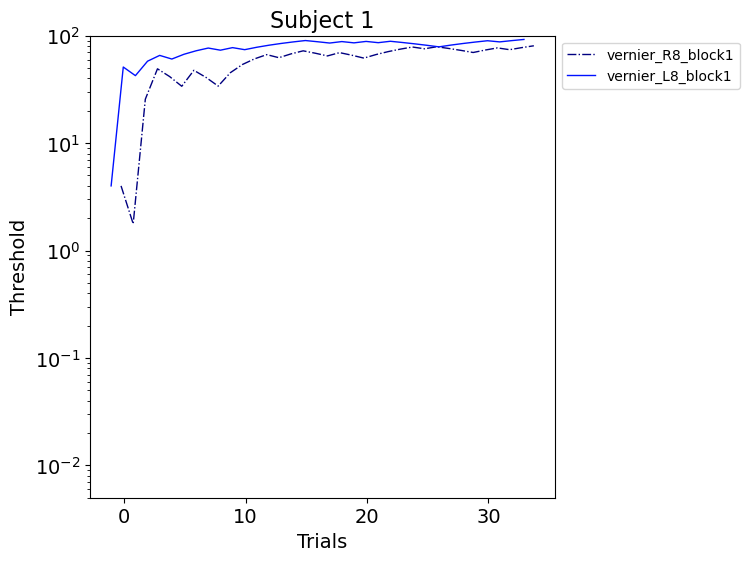

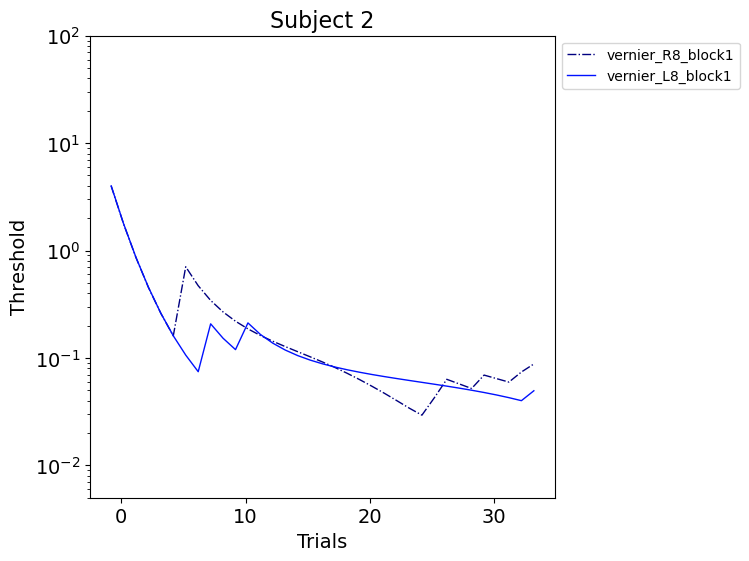

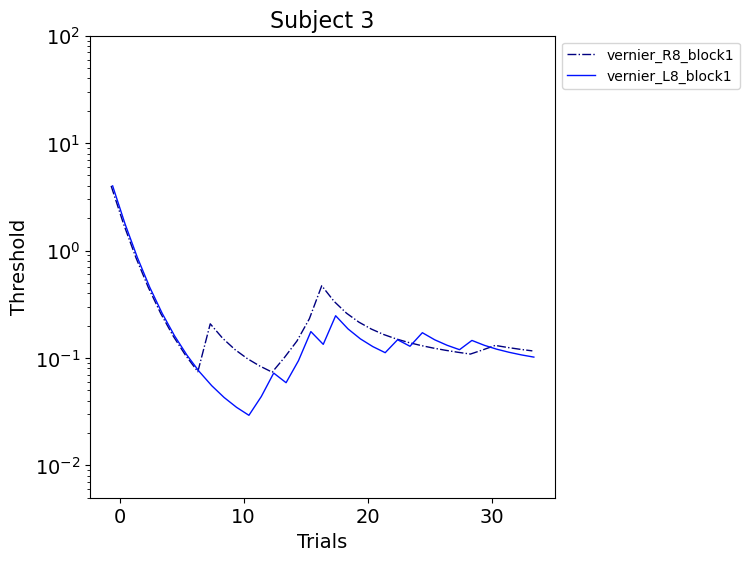

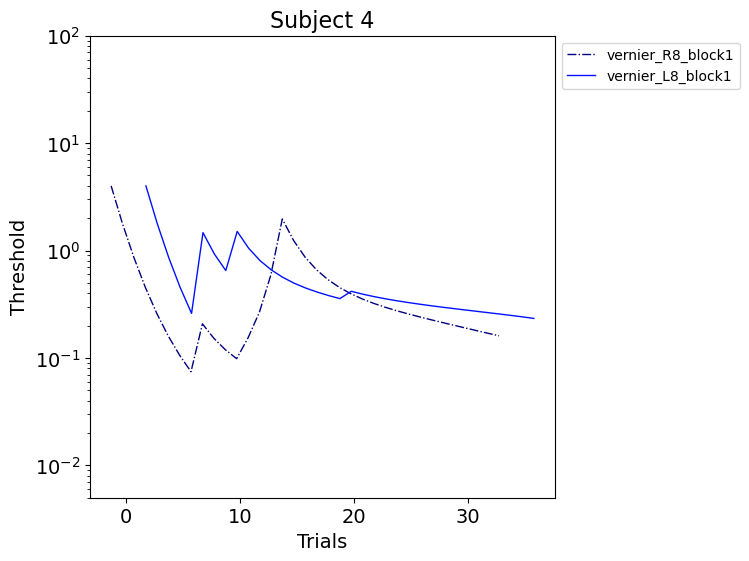

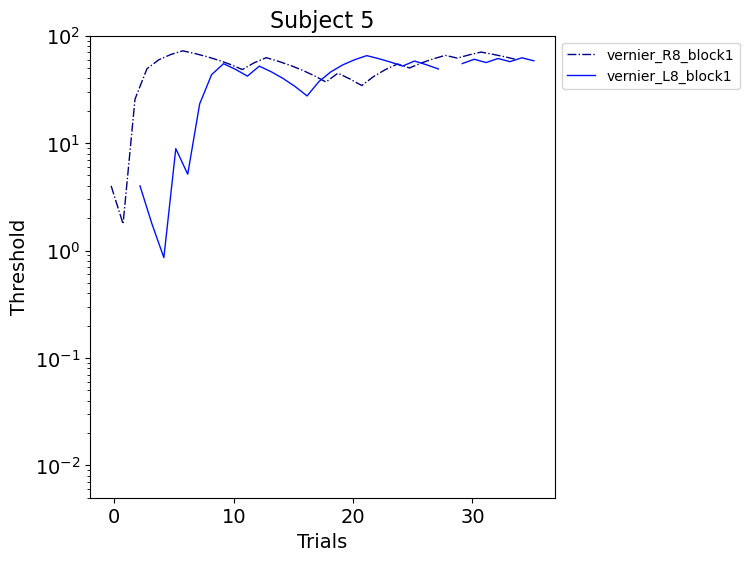

In [5]:
mydir = 'data/corr_firstSess'
files = [f for f in os.listdir(mydir) if f.endswith('.csv')]
num_subj = len(files)
condition_names = ['vernier_R8_block1', 'vernier_L8_block1']
                 
for subj in range(num_subj):
    filepath = os.path.join(mydir, files[subj])

    plotStaircase_LR(filepath, condition_names, subj+1)

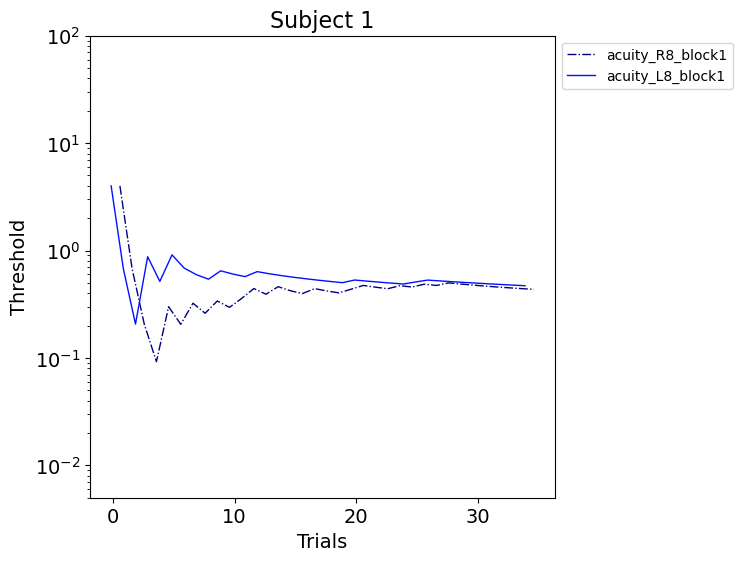

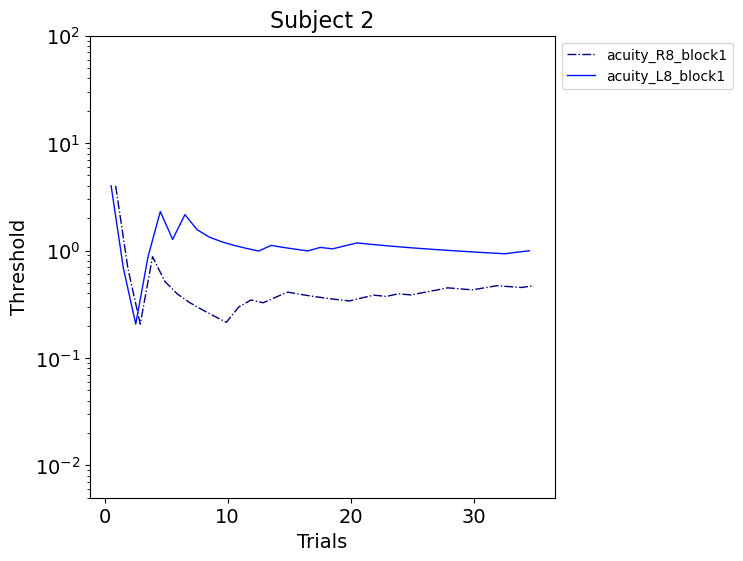

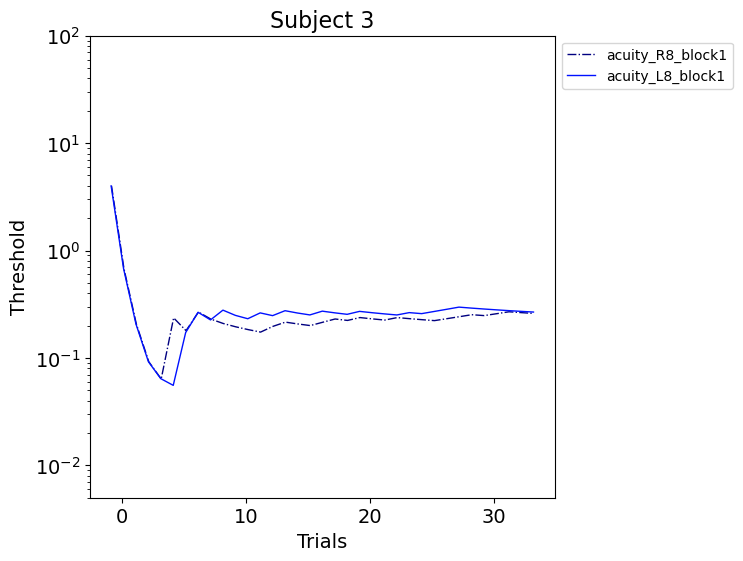

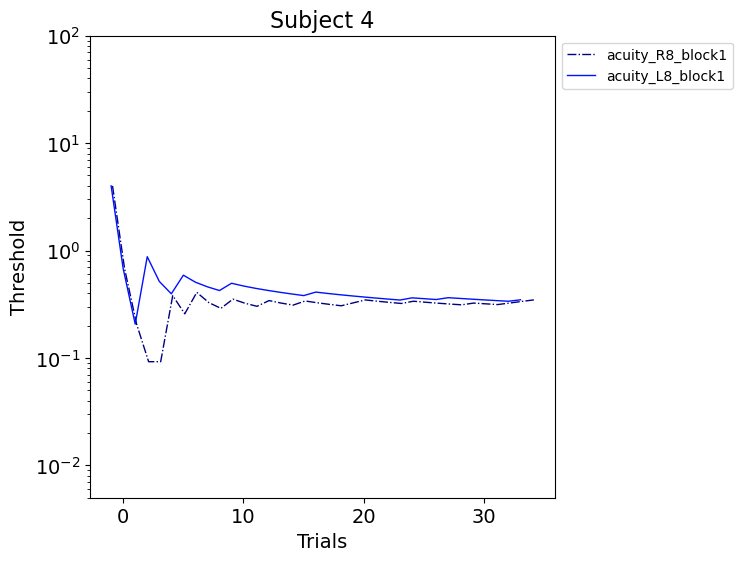

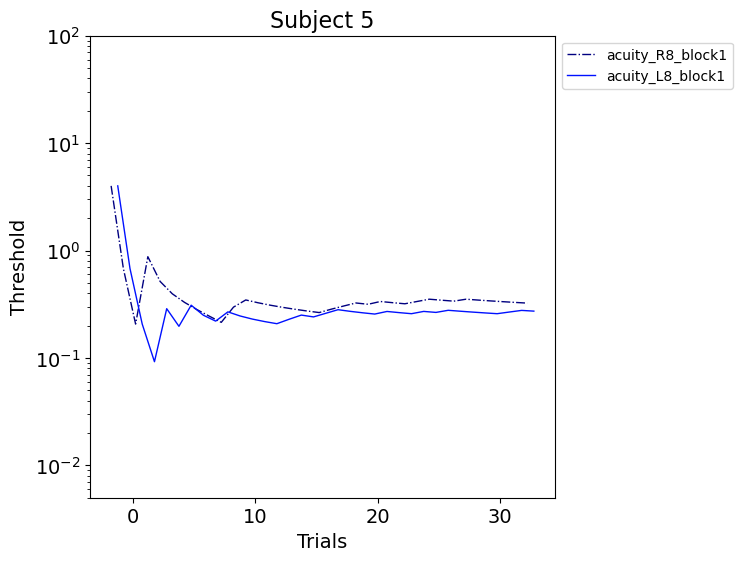

In [6]:
mydir = 'data/corr_firstSess'
files = [f for f in os.listdir(mydir) if f.endswith('.csv')]
num_subj = len(files)
condition_names = ['acuity_R8_block1', 'acuity_L8_block1']
                 
for subj in range(num_subj):
    filepath = os.path.join(mydir, files[subj])

    plotStaircase_LR(filepath, condition_names, subj+1)

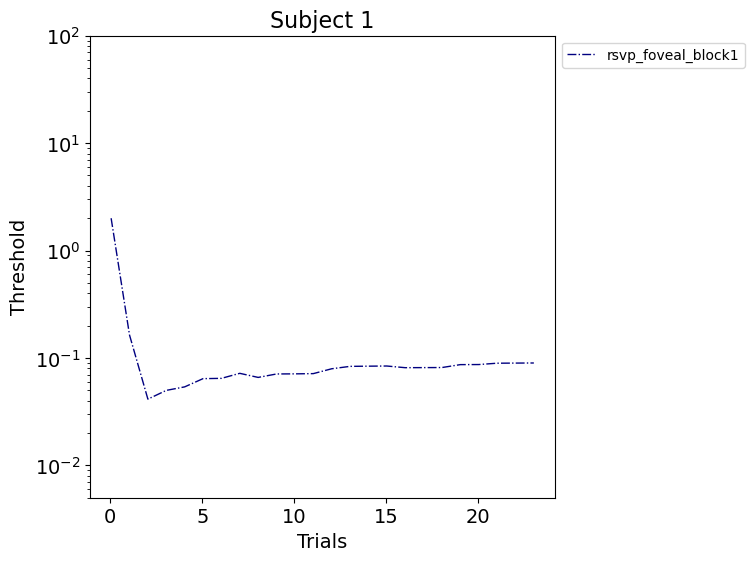

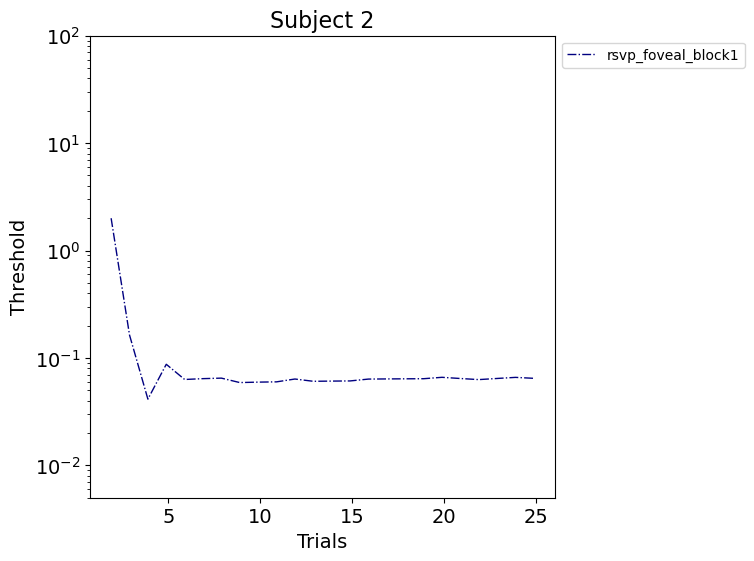

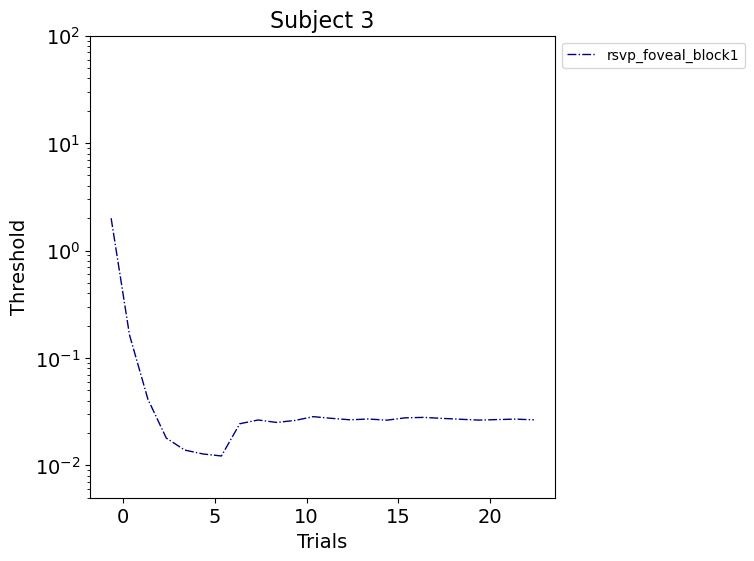

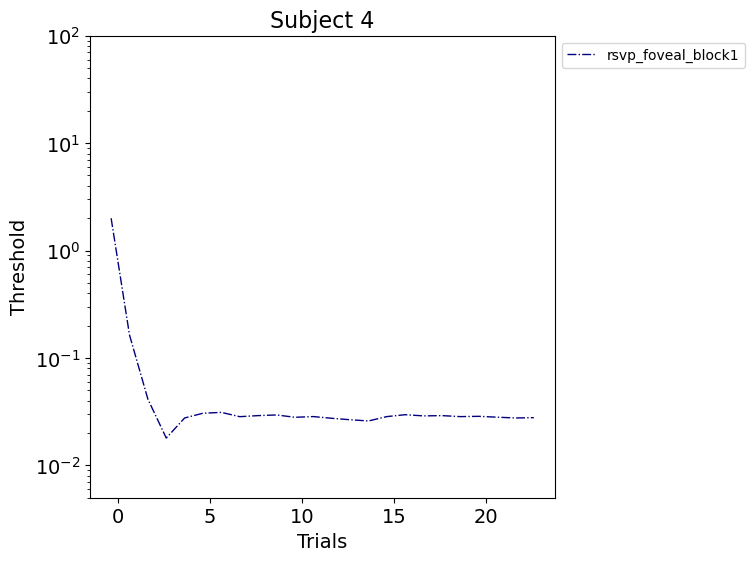

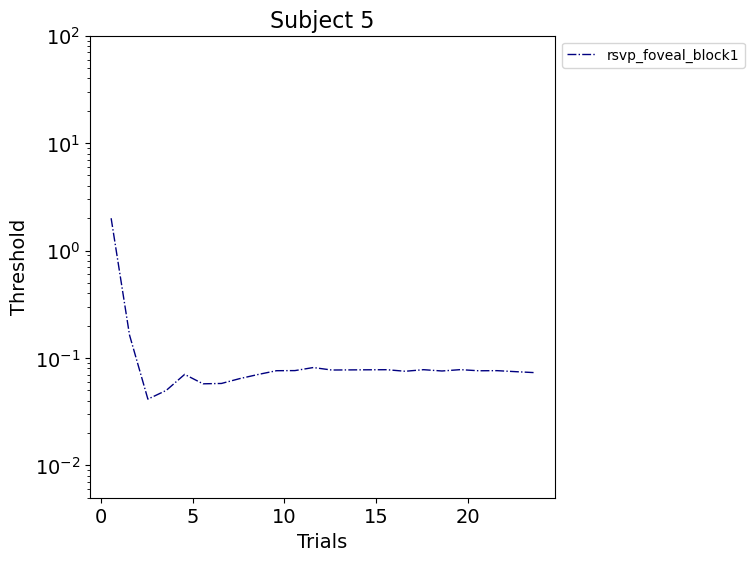

In [7]:
mydir = 'data/corr_firstSess'
files = [f for f in os.listdir(mydir) if f.endswith('.csv')]
num_subj = len(files)
condition_names = ['rsvp_foveal_block1']
                 
for subj in range(num_subj):
    filepath = os.path.join(mydir, files[subj])

    plotStaircase_LR(filepath, condition_names, subj+1)

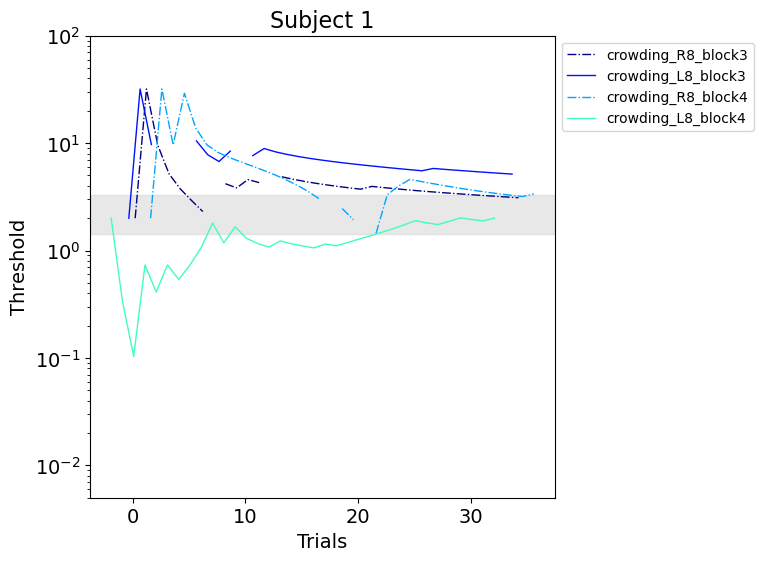

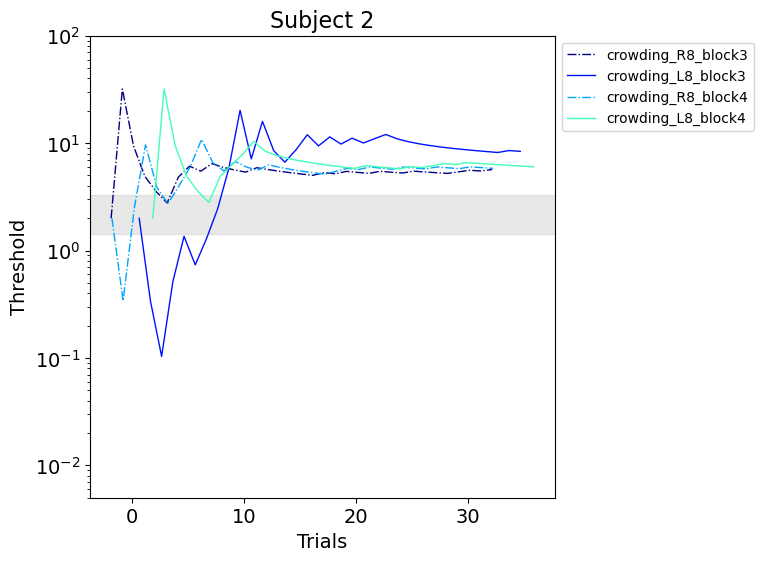

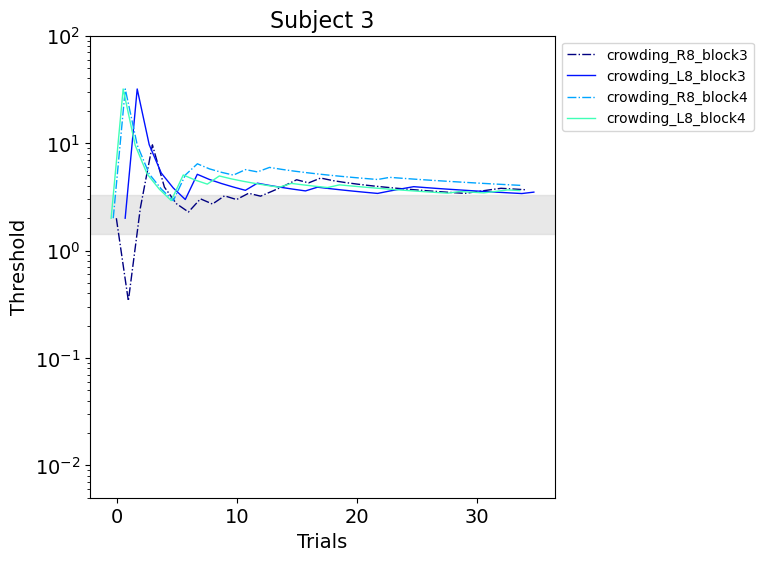

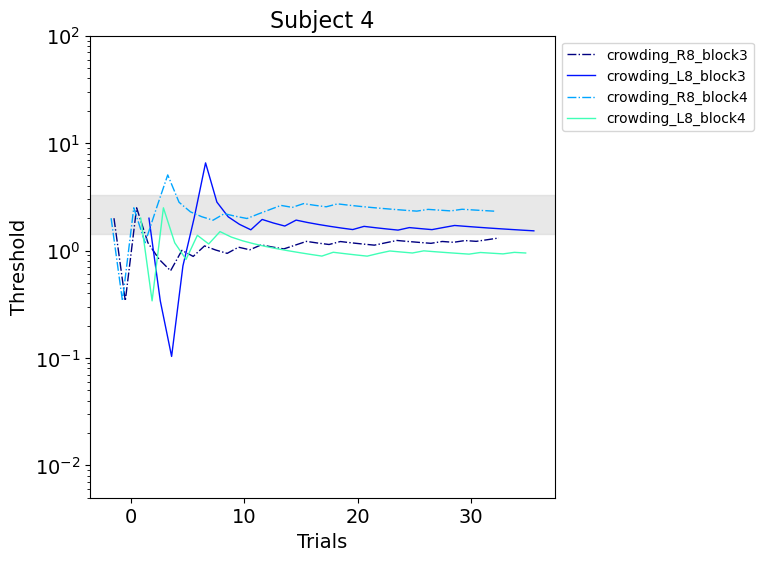

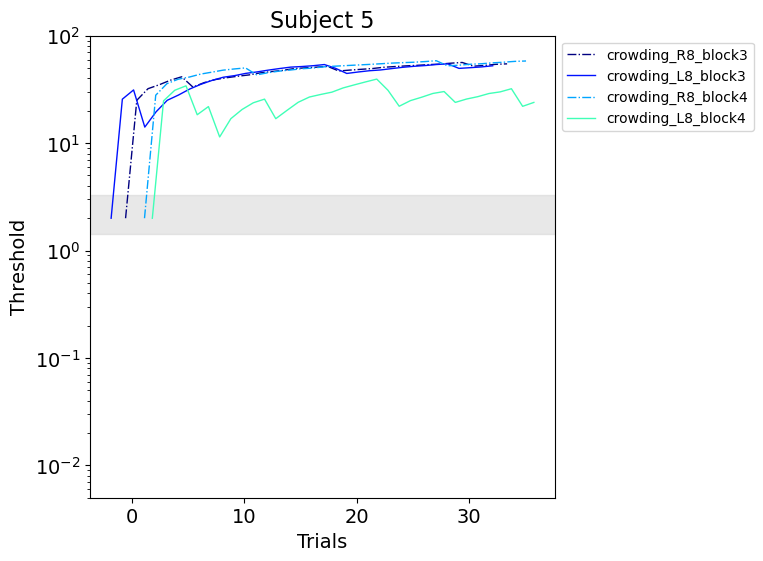

In [8]:
mydir = 'data/corr_secondSess'
files = [f for f in os.listdir(mydir) if f.endswith('.csv')]
num_subj = len(files)
condition_names = ['crowding_R8_block3', 'crowding_L8_block3',
                  'crowding_R8_block4', 'crowding_L8_block4']
                 
for subj in range(num_subj):
    filepath = os.path.join(mydir, files[subj])

    plotStaircase_LR(filepath, condition_names, subj+1, dispTypicalCrowdingThresholds = True)

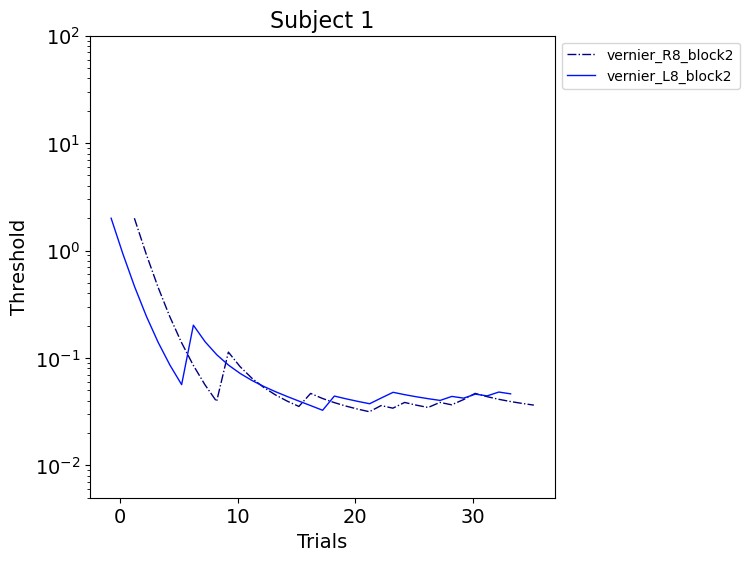

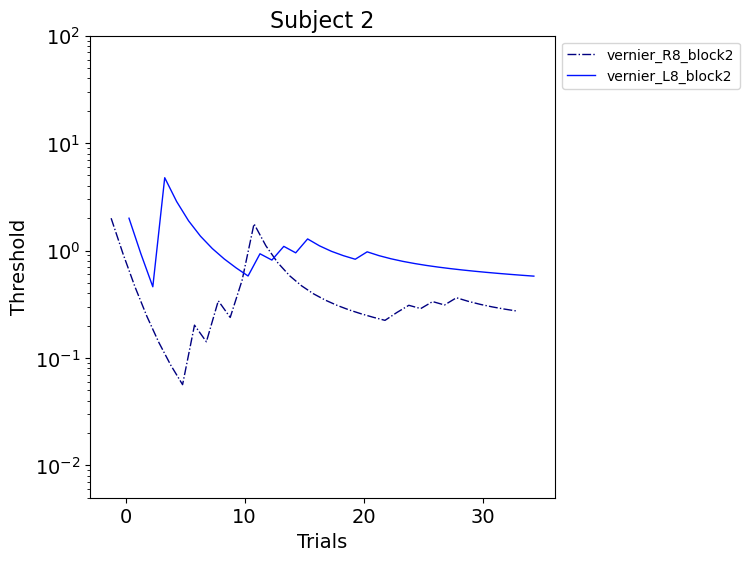

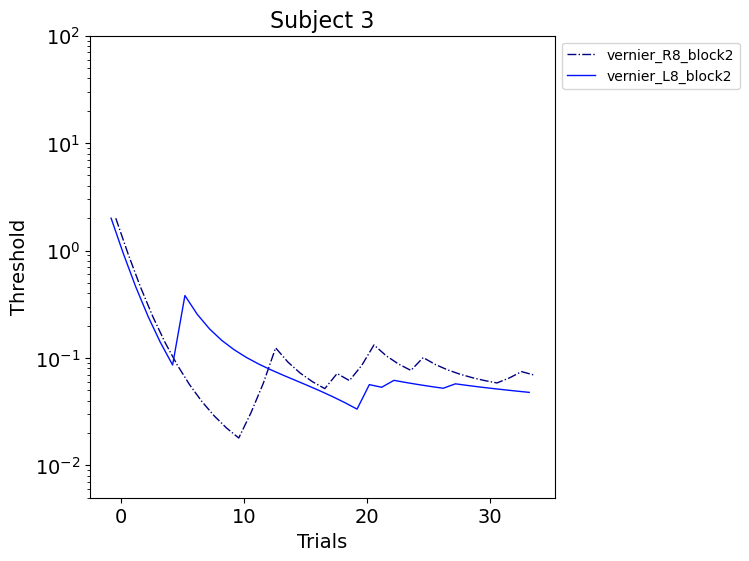

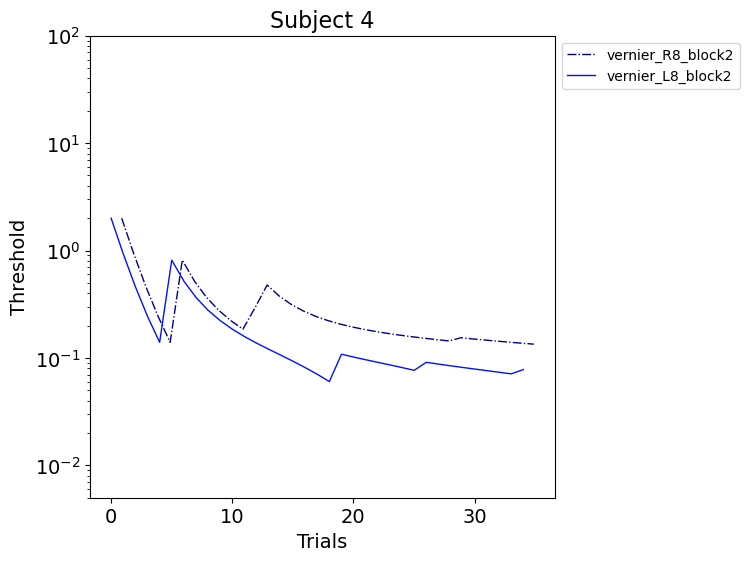

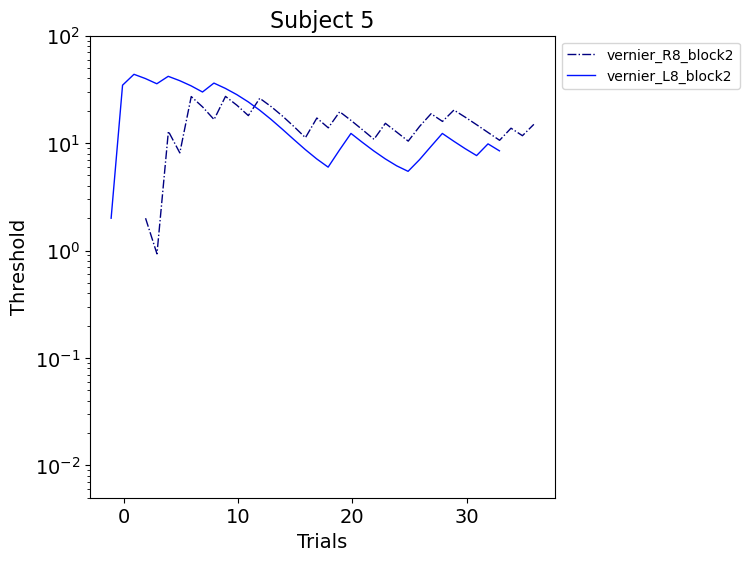

In [9]:
mydir = 'data/corr_secondSess'
files = [f for f in os.listdir(mydir) if f.endswith('.csv')]
num_subj = len(files)
condition_names = ['vernier_R8_block2', 'vernier_L8_block2']
                 
for subj in range(num_subj):
    filepath = os.path.join(mydir, files[subj])

    plotStaircase_LR(filepath, condition_names, subj+1)

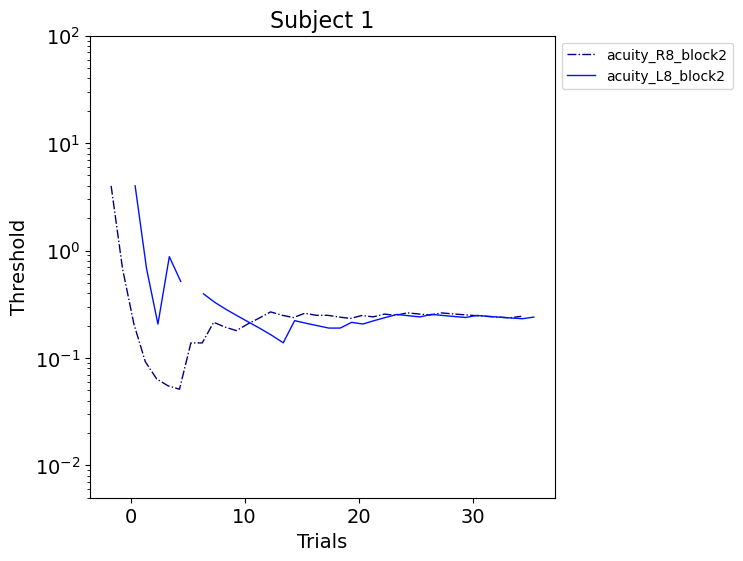

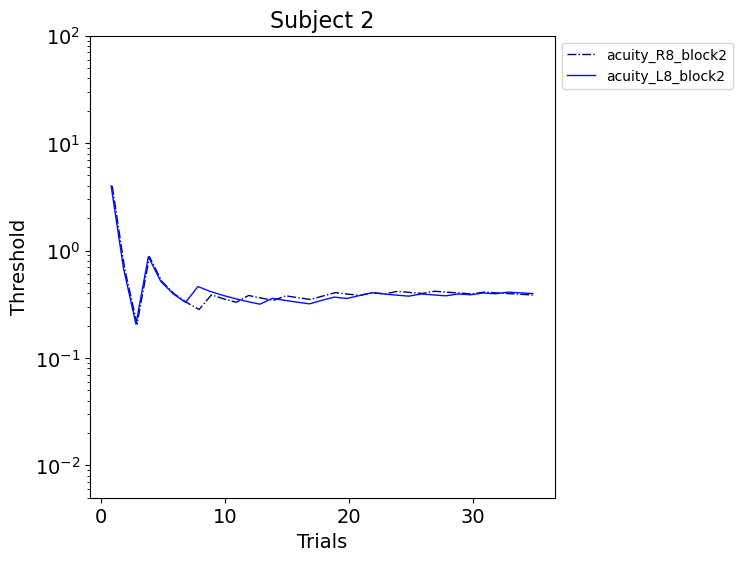

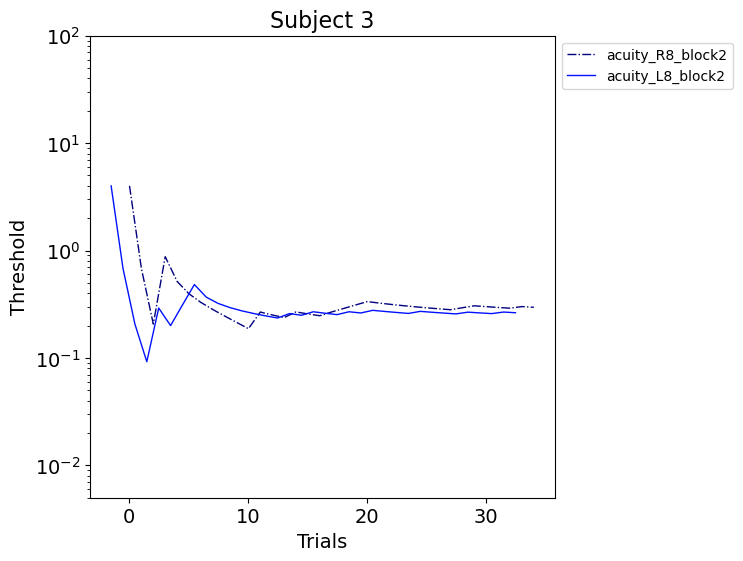

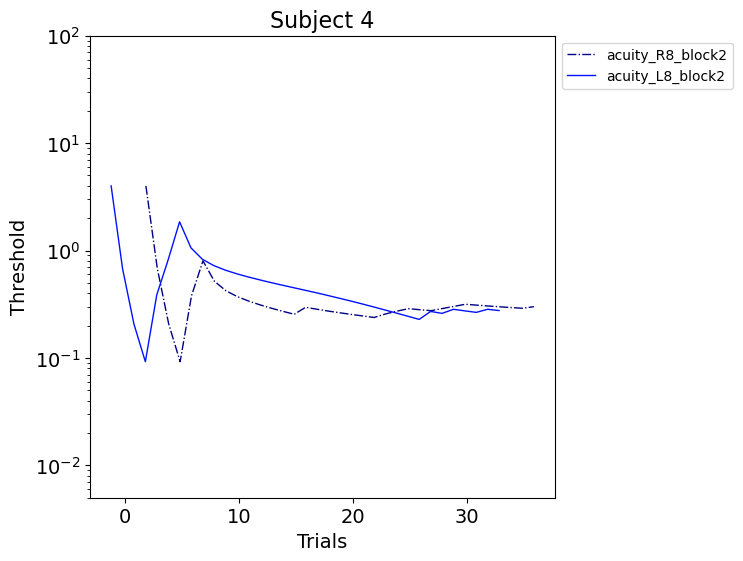

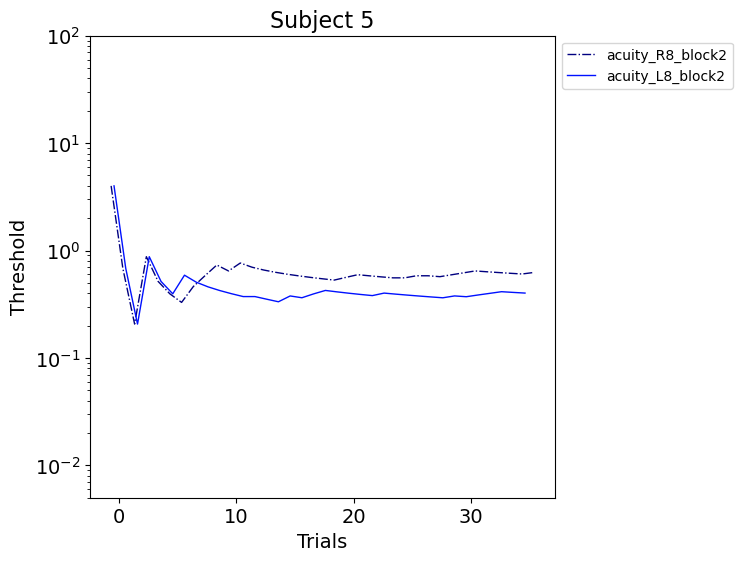

In [10]:
mydir = 'data/corr_secondSess'
files = [f for f in os.listdir(mydir) if f.endswith('.csv')]
num_subj = len(files)
condition_names = ['acuity_R8_block2', 'acuity_L8_block2']
                 
for subj in range(num_subj):
    filepath = os.path.join(mydir, files[subj])

    plotStaircase_LR(filepath, condition_names, subj+1)

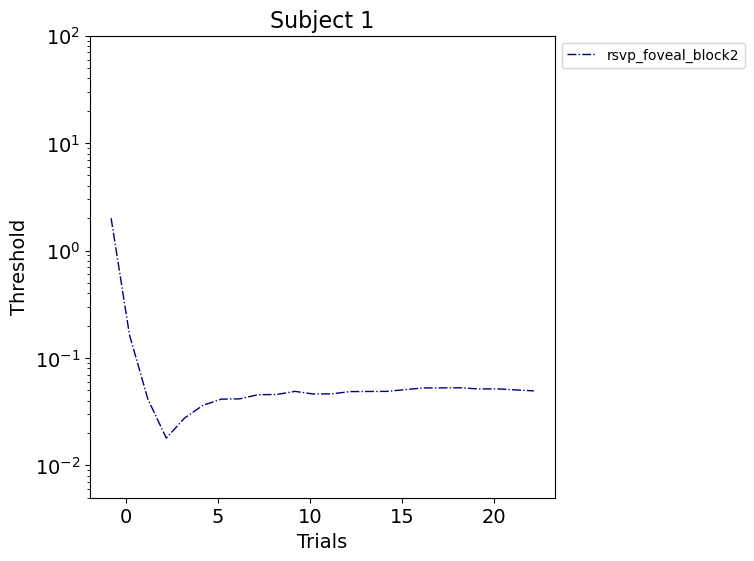

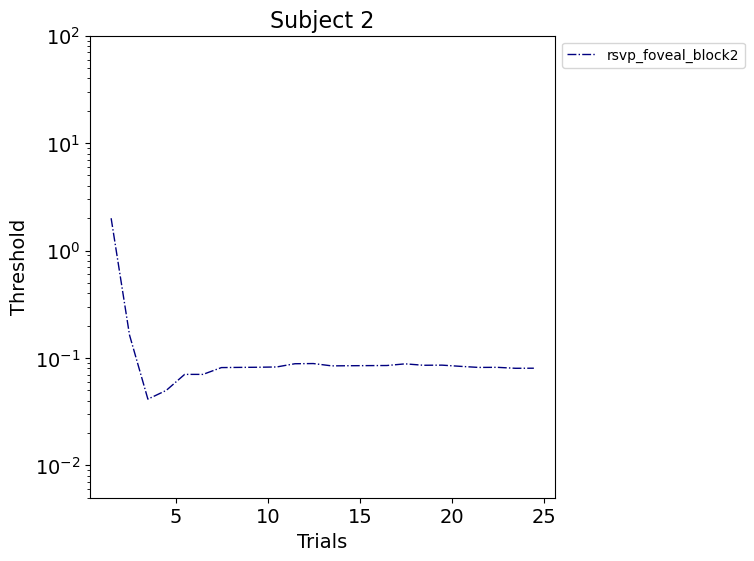

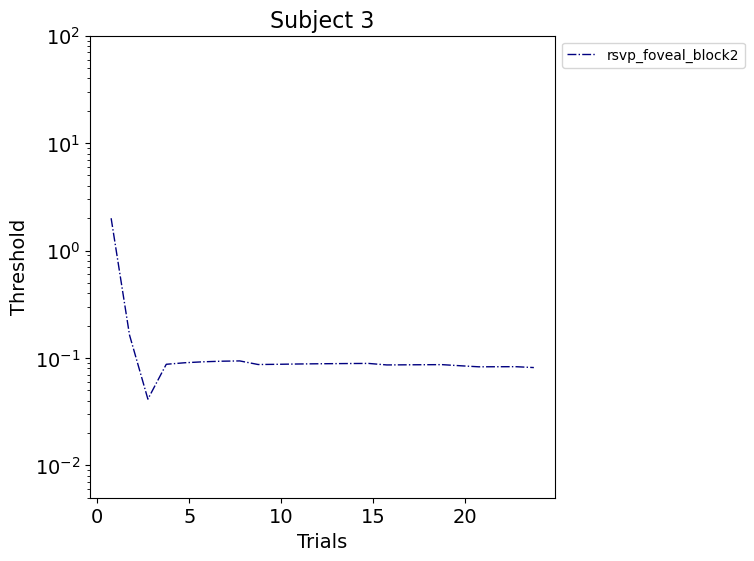

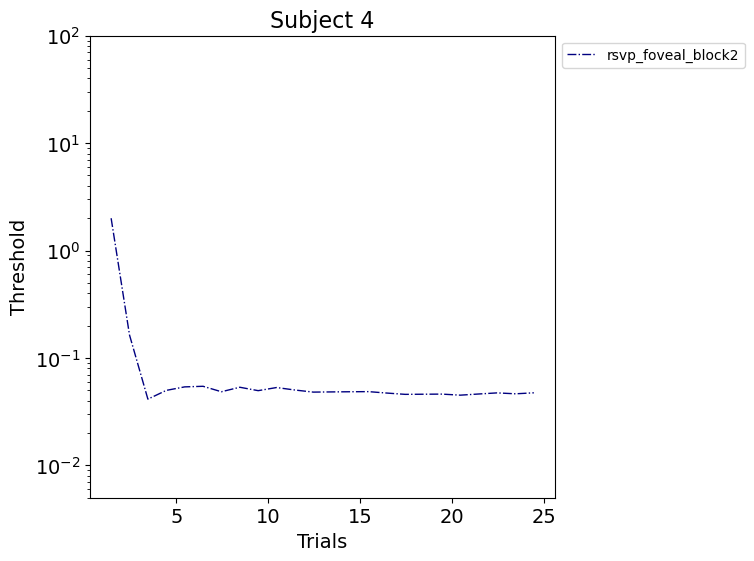

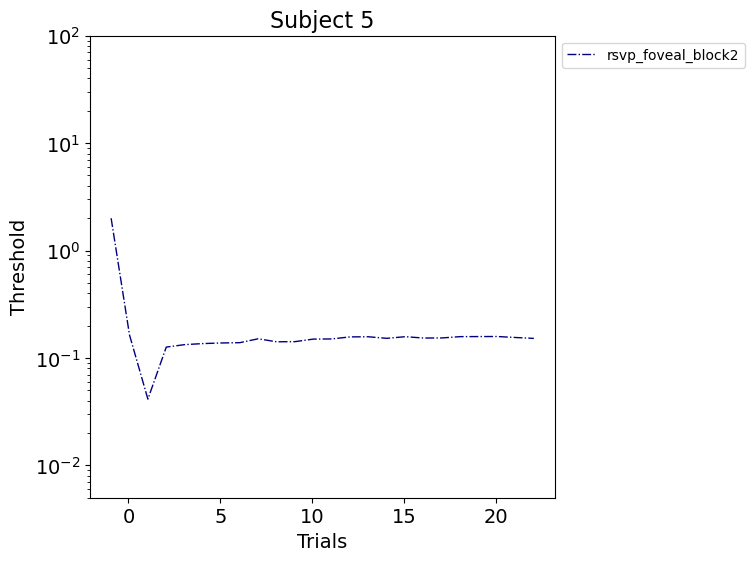

In [11]:
mydir = 'data/corr_secondSess'
files = [f for f in os.listdir(mydir) if f.endswith('.csv')]
num_subj = len(files)
condition_names = ['rsvp_foveal_block2']
                 
for subj in range(num_subj):
    filepath = os.path.join(mydir, files[subj])

    plotStaircase_LR(filepath, condition_names, subj+1)